# Analysis Notebook for "Dialog without Dialog Data: Learning Visual DialogAgents from VQA Data"

This notebook produces the table displayed in the README.

It starts with some [setup code](#Setup-Code) that loads relevant libraries and then loads the results computed by `run.py -m analyze` and stored in individual experiment directories. The [parse the results](#Parse-the-Results) section then parses these results into a pandas DataFrame.

Finally, the [Main Results](#Main-Results) and [Per-Round Accuracy](#Per-Round-Accuracy) sections aggregate and report the results.

# Setup Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os.path as pth
import re
import glob
from functools import reduce, partial

import pandas as pd
import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import PIL

from IPython.display import HTML, display

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import models.questioner
import models.answerer

import misc.utilities as utils
import misc.dataloader

from jinja2 import Template

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
# A few torch cuda tensors got saved. Monkey patch loading
# so the notebook doesn't need a gpu.
torch.load = partial(torch.load, map_location='cpu')

In [6]:
f_exp_vers = lambda s, fill=True, start='exp': tuple(list(map(int, s[len(start):].split('.'))) + [0] * (100 if fill else 0))
                                                     

In [7]:
file_cache = {}

In [8]:
exps = [
# Stage 1 (160507)
'exp15.0.1.0.0',
# Stage 2.A (160676)
'exp19.0.0.0.1',
'exp19.1.0.0.1',
'exp19.2.0.0.1',
'exp19.3.0.0.1',
'exp19.1.0.1.1',
'exp19.2.0.1.1',
'exp19.3.0.1.1',
'exp19.1.0.2.1',
'exp19.2.0.2.1',
'exp19.3.0.2.1',
# Stage 2.B
'exp20.0.2.0',
'exp20.1.2.0',
'exp20.2.2.0',
'exp20.3.2.0',
'exp20.1.2.1',
'exp20.2.2.1',
'exp20.3.2.1',
'exp20.1.2.2',
'exp20.2.2.2',
'exp20.3.2.2',
# Direct to Stage 2.B (160680)
'exp19.0.3.0.1',
'exp19.1.3.0.1',
'exp19.2.3.0.1',
'exp19.3.3.0.1',
'exp19.1.3.1.1',
'exp19.2.3.1.1',
'exp19.3.3.1.1',
'exp19.1.3.2.1',
'exp19.2.3.2.1',
'exp19.3.3.2.1',
# Parallel Speaker (160684)
'exp19.0.2.0.1',
'exp19.1.2.0.1',
'exp19.2.2.0.1',
'exp19.3.2.0.1',
'exp19.1.2.1.1',
'exp19.2.2.1.1',
'exp19.3.2.1.1',
'exp19.1.2.2.1',
'exp19.2.2.2.1',
'exp19.3.2.2.1',
# Fine Decoder (160688)
'exp19.0.1.0.1',
'exp19.1.1.0.1',
'exp19.2.1.0.1',
'exp19.3.1.0.1',
'exp19.1.1.1.1',
'exp19.2.1.1.1',
'exp19.3.1.1.1',
'exp19.1.1.2.1',
'exp19.2.1.2.1',
'exp19.3.1.2.1',
# Only Stage 2.A (160692)
'exp19.0.0.0.5',
'exp19.1.0.0.5',
'exp19.2.0.0.5',
'exp19.3.0.0.5',
'exp19.1.0.1.5',
'exp19.2.0.1.5',
'exp19.3.0.1.5',
'exp19.1.0.2.5',
'exp19.2.0.2.5',
'exp19.3.0.2.5',
# Cont Stage 1
'exp15.1.0.0.0',
# Cont Stage 2.A
'exp19.0.0.0.3',
'exp19.1.0.0.3',
'exp19.2.0.0.3',
'exp19.3.0.0.3',
'exp19.1.0.1.3',
'exp19.2.0.1.3',
'exp19.3.0.1.3',
'exp19.1.0.2.3',
'exp19.2.0.2.3',
'exp19.3.0.2.3',
# Cont Stage 2.B
'exp20.0.4.0',
'exp20.1.4.0',
'exp20.2.4.0',
'exp20.3.4.0',
'exp20.1.4.1',
'exp20.2.4.1',
'exp20.3.4.1',
'exp20.1.4.2',
'exp20.2.4.2',
'exp20.3.4.2',
# Cont Direct to Stage 2.B
'exp19.0.3.0.3',
'exp19.1.3.0.3',
'exp19.2.3.0.3',
'exp19.3.3.0.3',
'exp19.1.3.1.3',
'exp19.2.3.1.3',
'exp19.3.3.1.3',
'exp19.1.3.2.3',
'exp19.2.3.2.3',
'exp19.3.3.2.3',
# Cont Parallel Speaker
'exp19.0.2.0.3',
'exp19.1.2.0.3',
'exp19.2.2.0.3',
'exp19.3.2.0.3',
'exp19.1.2.1.3',
'exp19.2.2.1.3',
'exp19.3.2.1.3',
'exp19.1.2.2.3',
'exp19.2.2.2.3',
'exp19.3.2.2.3',
# Cont Fine Decoder
'exp19.0.1.0.3',
'exp19.1.1.0.3',
'exp19.2.1.0.3',
'exp19.3.1.0.3',
'exp19.1.1.1.3',
'exp19.2.1.1.3',
'exp19.3.1.1.3',
'exp19.1.1.2.3',
'exp19.2.1.2.3',
'exp19.3.1.2.3',
# Non-Var Cont Stage 1
'exp15.2.0.0.0',
# Non-Var Cont Stage 2.A
'exp19.0.0.0.4',
'exp19.1.0.0.4',
'exp19.2.0.0.4',
'exp19.3.0.0.4',
'exp19.1.0.1.4',
'exp19.2.0.1.4',
'exp19.3.0.1.4',
'exp19.1.0.2.4',
'exp19.2.0.2.4',
'exp19.3.0.2.4',
# Non-Var Cont Stage 2.B
'exp20.0.5.0',
'exp20.1.5.0',
'exp20.2.5.0',
'exp20.3.5.0',
'exp20.1.5.1',
'exp20.2.5.1',
'exp20.3.5.1',
'exp20.1.5.2',
'exp20.2.5.2',
'exp20.3.5.2',
# Non-Var Cont Direct to Stage 2.B
'exp19.0.3.0.4',
'exp19.1.3.0.4',
'exp19.2.3.0.4',
'exp19.3.3.0.4',
'exp19.1.3.1.4',
'exp19.2.3.1.4',
'exp19.3.3.1.4',
'exp19.1.3.2.4',
'exp19.2.3.2.4',
'exp19.3.3.2.4',
# Non-Var Cont Parallel Speaker
'exp19.0.2.0.4',
'exp19.1.2.0.4',
'exp19.2.2.0.4',
'exp19.3.2.0.4',
'exp19.1.2.1.4',
'exp19.2.2.1.4',
'exp19.3.2.1.4',
'exp19.1.2.2.4',
'exp19.2.2.2.4',
'exp19.3.2.2.4',
# Non-Var Cont Fine Decoder
'exp19.0.1.0.4',
'exp19.1.1.0.4',
'exp19.2.1.0.4',
'exp19.3.1.0.4',
'exp19.1.1.1.4',
'exp19.2.1.1.4',
'exp19.3.1.1.4',
'exp19.1.1.2.4',
'exp19.2.1.2.4',
'exp19.3.1.2.4',
]

In [9]:
unique_dfs = []
eval_dfs = []

skipped = 0
loaded = 0
cached = 0
for exp in exps:
    # these need to explicitly use the new abot
    split = 'val'
    if split == 'val':
        eval_exps = [
            'eval1.0.0.1.3',
            'eval1.1.0.1.3',
            'eval1.2.0.1.3',
            'eval1.3.0.1.3',
        ]
        if exp.startswith('exp15'):
            eval_exps += [
                'eval1.0.0.1.1',
                'eval1.1.0.1.1',
                'eval1.2.0.1.1',
                'eval1.3.0.1.1',
                'eval1.0.0.1.2',
                'eval1.1.0.1.2',
                'eval1.2.0.1.2',
                'eval1.3.0.1.2',
            ]
    elif split == 'test':
        eval_exps = [
            'eval4.4.0.1.3',
            'eval4.1.0.1.3',
            'eval4.2.0.1.3',
            'eval4.3.0.1.3',
        ]
        if exp.startswith('exp15'):
            eval_exps += [
                'eval4.0.0.1.1',
                'eval4.1.0.1.1',
                'eval4.2.0.1.1',
                'eval4.3.0.1.1',
                'eval4.0.0.1.2',
                'eval4.1.0.1.2',
                'eval4.2.0.1.2',
                'eval4.3.0.1.2',
            ]

    for eval_exp in eval_exps:
        fname = 'data/experiments/{}/{}.joblib'.format(exp, eval_exp)
        print(f'{exp} {eval_exp}')
        if fname in file_cache:
            data = file_cache[fname]
            cached += 1
        elif pth.exists(fname):
            data = joblib.load(fname)
            data['eval_df']['exp'] = exp
            data['eval_df']['eval_exp'] = eval_exp
            file_cache[fname] = data
            loaded += 1
            print('loading: ', fname)
        else:
            skipped += 1
            print('skipping: ', fname)
            match = re.search('\/(exp\d+(?:\.\d+)*)\/', fname)
            print(match.groups(1)[0] + ' ', end='')
            match = re.search('\/(eval\d+(?:\.\d+)*).joblib', fname)
            print(match.groups(1)[0])
            continue
        if 'unique_df' in data:
            unique_dfs.append(data['unique_df'])
        eval_dfs.append(data['eval_df'])
            
            
print('skipped {}'.format(skipped))
print('loaded {}'.format(loaded))
print('cached {}'.format(cached))

exp15.0.1.0.0 eval1.0.0.1.3
loading:  data/experiments/exp15.0.1.0.0/eval1.0.0.1.3.joblib
exp15.0.1.0.0 eval1.1.0.1.3
loading:  data/experiments/exp15.0.1.0.0/eval1.1.0.1.3.joblib
exp15.0.1.0.0 eval1.2.0.1.3
loading:  data/experiments/exp15.0.1.0.0/eval1.2.0.1.3.joblib
exp15.0.1.0.0 eval1.3.0.1.3
loading:  data/experiments/exp15.0.1.0.0/eval1.3.0.1.3.joblib
exp15.0.1.0.0 eval1.0.0.1.1
loading:  data/experiments/exp15.0.1.0.0/eval1.0.0.1.1.joblib
exp15.0.1.0.0 eval1.1.0.1.1
loading:  data/experiments/exp15.0.1.0.0/eval1.1.0.1.1.joblib
exp15.0.1.0.0 eval1.2.0.1.1
loading:  data/experiments/exp15.0.1.0.0/eval1.2.0.1.1.joblib
exp15.0.1.0.0 eval1.3.0.1.1
loading:  data/experiments/exp15.0.1.0.0/eval1.3.0.1.1.joblib
exp15.0.1.0.0 eval1.0.0.1.2
loading:  data/experiments/exp15.0.1.0.0/eval1.0.0.1.2.joblib
exp15.0.1.0.0 eval1.1.0.1.2
loading:  data/experiments/exp15.0.1.0.0/eval1.1.0.1.2.joblib
exp15.0.1.0.0 eval1.2.0.1.2
loading:  data/experiments/exp15.0.1.0.0/eval1.2.0.1.2.joblib
exp15.0.1.

loading:  data/experiments/exp19.1.3.1.1/eval1.2.0.1.3.joblib
exp19.1.3.1.1 eval1.3.0.1.3
loading:  data/experiments/exp19.1.3.1.1/eval1.3.0.1.3.joblib
exp19.2.3.1.1 eval1.0.0.1.3
loading:  data/experiments/exp19.2.3.1.1/eval1.0.0.1.3.joblib
exp19.2.3.1.1 eval1.1.0.1.3
loading:  data/experiments/exp19.2.3.1.1/eval1.1.0.1.3.joblib
exp19.2.3.1.1 eval1.2.0.1.3
loading:  data/experiments/exp19.2.3.1.1/eval1.2.0.1.3.joblib
exp19.2.3.1.1 eval1.3.0.1.3
loading:  data/experiments/exp19.2.3.1.1/eval1.3.0.1.3.joblib
exp19.3.3.1.1 eval1.0.0.1.3
loading:  data/experiments/exp19.3.3.1.1/eval1.0.0.1.3.joblib
exp19.3.3.1.1 eval1.1.0.1.3
loading:  data/experiments/exp19.3.3.1.1/eval1.1.0.1.3.joblib
exp19.3.3.1.1 eval1.2.0.1.3
loading:  data/experiments/exp19.3.3.1.1/eval1.2.0.1.3.joblib
exp19.3.3.1.1 eval1.3.0.1.3
loading:  data/experiments/exp19.3.3.1.1/eval1.3.0.1.3.joblib
exp19.1.3.2.1 eval1.0.0.1.3
loading:  data/experiments/exp19.1.3.2.1/eval1.0.0.1.3.joblib
exp19.1.3.2.1 eval1.1.0.1.3
loading:  

loading:  data/experiments/exp19.3.0.1.5/eval1.1.0.1.3.joblib
exp19.3.0.1.5 eval1.2.0.1.3
loading:  data/experiments/exp19.3.0.1.5/eval1.2.0.1.3.joblib
exp19.3.0.1.5 eval1.3.0.1.3
loading:  data/experiments/exp19.3.0.1.5/eval1.3.0.1.3.joblib
exp19.1.0.2.5 eval1.0.0.1.3
loading:  data/experiments/exp19.1.0.2.5/eval1.0.0.1.3.joblib
exp19.1.0.2.5 eval1.1.0.1.3
loading:  data/experiments/exp19.1.0.2.5/eval1.1.0.1.3.joblib
exp19.1.0.2.5 eval1.2.0.1.3
loading:  data/experiments/exp19.1.0.2.5/eval1.2.0.1.3.joblib
exp19.1.0.2.5 eval1.3.0.1.3
loading:  data/experiments/exp19.1.0.2.5/eval1.3.0.1.3.joblib
exp19.2.0.2.5 eval1.0.0.1.3
loading:  data/experiments/exp19.2.0.2.5/eval1.0.0.1.3.joblib
exp19.2.0.2.5 eval1.1.0.1.3
loading:  data/experiments/exp19.2.0.2.5/eval1.1.0.1.3.joblib
exp19.2.0.2.5 eval1.2.0.1.3
loading:  data/experiments/exp19.2.0.2.5/eval1.2.0.1.3.joblib
exp19.2.0.2.5 eval1.3.0.1.3
loading:  data/experiments/exp19.2.0.2.5/eval1.3.0.1.3.joblib
exp19.3.0.2.5 eval1.0.0.1.3
loading:  

loading:  data/experiments/exp20.1.4.2/eval1.0.0.1.3.joblib
exp20.1.4.2 eval1.1.0.1.3
loading:  data/experiments/exp20.1.4.2/eval1.1.0.1.3.joblib
exp20.1.4.2 eval1.2.0.1.3
loading:  data/experiments/exp20.1.4.2/eval1.2.0.1.3.joblib
exp20.1.4.2 eval1.3.0.1.3
loading:  data/experiments/exp20.1.4.2/eval1.3.0.1.3.joblib
exp20.2.4.2 eval1.0.0.1.3
loading:  data/experiments/exp20.2.4.2/eval1.0.0.1.3.joblib
exp20.2.4.2 eval1.1.0.1.3
loading:  data/experiments/exp20.2.4.2/eval1.1.0.1.3.joblib
exp20.2.4.2 eval1.2.0.1.3
loading:  data/experiments/exp20.2.4.2/eval1.2.0.1.3.joblib
exp20.2.4.2 eval1.3.0.1.3
loading:  data/experiments/exp20.2.4.2/eval1.3.0.1.3.joblib
exp20.3.4.2 eval1.0.0.1.3
loading:  data/experiments/exp20.3.4.2/eval1.0.0.1.3.joblib
exp20.3.4.2 eval1.1.0.1.3
loading:  data/experiments/exp20.3.4.2/eval1.1.0.1.3.joblib
exp20.3.4.2 eval1.2.0.1.3
loading:  data/experiments/exp20.3.4.2/eval1.2.0.1.3.joblib
exp20.3.4.2 eval1.3.0.1.3
loading:  data/experiments/exp20.3.4.2/eval1.3.0.1.3.j

loading:  data/experiments/exp19.1.1.2.3/eval1.2.0.1.3.joblib
exp19.1.1.2.3 eval1.3.0.1.3
loading:  data/experiments/exp19.1.1.2.3/eval1.3.0.1.3.joblib
exp19.2.1.2.3 eval1.0.0.1.3
loading:  data/experiments/exp19.2.1.2.3/eval1.0.0.1.3.joblib
exp19.2.1.2.3 eval1.1.0.1.3
loading:  data/experiments/exp19.2.1.2.3/eval1.1.0.1.3.joblib
exp19.2.1.2.3 eval1.2.0.1.3
loading:  data/experiments/exp19.2.1.2.3/eval1.2.0.1.3.joblib
exp19.2.1.2.3 eval1.3.0.1.3
loading:  data/experiments/exp19.2.1.2.3/eval1.3.0.1.3.joblib
exp19.3.1.2.3 eval1.0.0.1.3
loading:  data/experiments/exp19.3.1.2.3/eval1.0.0.1.3.joblib
exp19.3.1.2.3 eval1.1.0.1.3
loading:  data/experiments/exp19.3.1.2.3/eval1.1.0.1.3.joblib
exp19.3.1.2.3 eval1.2.0.1.3
loading:  data/experiments/exp19.3.1.2.3/eval1.2.0.1.3.joblib
exp19.3.1.2.3 eval1.3.0.1.3
loading:  data/experiments/exp19.3.1.2.3/eval1.3.0.1.3.joblib
exp15.2.0.0.0 eval1.0.0.1.3
loading:  data/experiments/exp15.2.0.0.0/eval1.0.0.1.3.joblib
exp15.2.0.0.0 eval1.1.0.1.3
loading:  

loading:  data/experiments/exp19.1.3.1.4/eval1.2.0.1.3.joblib
exp19.1.3.1.4 eval1.3.0.1.3
loading:  data/experiments/exp19.1.3.1.4/eval1.3.0.1.3.joblib
exp19.2.3.1.4 eval1.0.0.1.3
loading:  data/experiments/exp19.2.3.1.4/eval1.0.0.1.3.joblib
exp19.2.3.1.4 eval1.1.0.1.3
loading:  data/experiments/exp19.2.3.1.4/eval1.1.0.1.3.joblib
exp19.2.3.1.4 eval1.2.0.1.3
loading:  data/experiments/exp19.2.3.1.4/eval1.2.0.1.3.joblib
exp19.2.3.1.4 eval1.3.0.1.3
loading:  data/experiments/exp19.2.3.1.4/eval1.3.0.1.3.joblib
exp19.3.3.1.4 eval1.0.0.1.3
loading:  data/experiments/exp19.3.3.1.4/eval1.0.0.1.3.joblib
exp19.3.3.1.4 eval1.1.0.1.3
loading:  data/experiments/exp19.3.3.1.4/eval1.1.0.1.3.joblib
exp19.3.3.1.4 eval1.2.0.1.3
loading:  data/experiments/exp19.3.3.1.4/eval1.2.0.1.3.joblib
exp19.3.3.1.4 eval1.3.0.1.3
loading:  data/experiments/exp19.3.3.1.4/eval1.3.0.1.3.joblib
exp19.1.3.2.4 eval1.0.0.1.3
loading:  data/experiments/exp19.1.3.2.4/eval1.0.0.1.3.joblib
exp19.1.3.2.4 eval1.1.0.1.3
loading:  

loading:  data/experiments/exp19.3.1.2.4/eval1.3.0.1.3.joblib
skipped 6
loaded 670
cached 0


# Parse the Results

In [10]:
eval_df = pd.concat(eval_dfs, sort=True)

In [11]:
def unpack_exp_details(record):
    vers = f_exp_vers(record['exp'])
    eval_vers = f_exp_vers(record['eval_exp'], start='eval')
    result = []
    
    if eval_vers[0] == 1:
        record['eval_pool'] = {
            3: '9 random',
            2: '4 random',
            1: '2 random',
            0: '2 contrast',
            13: '9 easy',
            12: '4 easy',
            11: '2 easy',
            23: '9 hard',
            22: '4 hard',
            21: '2 hard',
        }[eval_vers[1]]
        record['eval_pool_size'] = int(record['eval_pool'].split(' ')[0])
        record['eval_pool_type'] = record['eval_pool'].split(' ')[1]
        if ((record['eval_pool_size'] == 2 and record['round'] == 0) or # 1 round
            (record['eval_pool_size'] == 4 and record['round'] == 4) or # 5 rounds
            (record['eval_pool_size'] == 9 and record['round'] == 8)): # 9 rounds
            record['eval_round'] = True
        else:
            record['eval_round'] = False
        if isinstance(record['distinct_ngrams'], dict):
            avg = 0
            for n in record['distinct_ngrams']:
                record[f'dngrams_{n}'] = 100 * record['distinct_ngrams'][n]
                avg += 100 * record['distinct_ngrams'][n]
            avg /= len(record['distinct_ngrams'])
            record['dngrams_avg'] = avg
            

    if vers[0] in [7, 8, 9, 15, 16, 17, 19, 20]:
        record['stage1_pool'] = '2 contrast'
        record['stage1_freeze'] = 'none'
    if vers[0] in [8, 9, 16, 17, 19, 20]:
        record['stage2_pool'] = {
            11: '2 easy',
            12: '4 easy',
            13: '9 easy',
            3: '9 random',
            2: '4 random',
            1: '2 random',
            0: '2 contrast',
        }[vers[1]]
        record['stage2_freeze'] = 'policy'
        if vers[2] == 1:
            record['stage2_freeze'] = 'none'
        if vers[3] != 0:
            record['stage2_freeze'] = 'other'
    if vers[0] in [9, 17, 20]:
        record['stage3_pool'] = {
            3: '9 random',
            2: '4 random',
            1: '2 random',
            0: '2 contrast',
        }[vers[1]]

    if vers[0] in [7, 15]:
        record['stage'] = 'pre'
        record['key'] = record['stage1_pool']
        record['final_pool'] = record['stage1_pool']
        if vers[1] == 2:
            record['speaker'] = 'two_part_continuous'
            record['key'] += ' (non-var continuous)'
        elif vers[1] == 1:
            record['speaker'] = 'two_part_continuous'
            record['key'] += ' (continuous)'
        elif vers[1] == 0:
            record['speaker'] = {
                0: 'two_part_zgrad',
                1: 'two_part_zgrad_logit',
                2: 'two_part_zgrad_codebook',
            }[vers[2]]
        record['dataset'] = 'VQA'
        stage = 1
    elif vers[0] in [8, 16, 19]:
        record['stage'] = 'fixed-speaker'
        record['final_pool'] = record['stage2_pool']
        record['key'] = ' - '.join([record['stage1_pool'], record['stage2_pool']])
        record['speaker'] = {
            0: 'two_part_zgrad',
            1: 'two_part_zgrad_logit',
            2: 'two_part_zgrad_codebook',
            3: 'two_part_continuous',
            4: 'non_var_continuous',
            5: 'two_part_logit_scratch',
            6: 'two_part_continuous_scratch',
        }[vers[4]]
        if vers[2] == 2:
            record['key'] += ' (par speaker)'
        elif vers[2] == 1:
            record['key'] += ' (fine decoder)'
        elif vers[2] == 3:
            record['key'] += ' (skip 2.A)'
        if vers[4] == 3:
            record['key'] += ' (continuous)'
        elif vers[4] == 4:
            record['key'] += ' (non-var continuous)'
        elif vers[4] == 5:
            record['key'] += ' (no stage 1)'
        elif vers[4] == 6:
            record['key'] += ' (no stage 1) (continuous)'
        record['dataset'] = {
            0: 'VQA',
            1: 'CUB',
            2: 'AWA',
        }[vers[3]]
        stage = 2
    elif vers[0] in [9, 17, 20]:
        record['stage'] = 'fine-tune'
        record['final_pool'] = record['stage3_pool']
        record['key'] = ' - '.join([record['stage1_pool'], record['stage2_pool'], record['stage3_pool']])
        record['speaker'] = {
            0: 'two_part_zgrad',
            1: 'two_part_zgrad',
            2: 'two_part_zgrad_logit',
            3: 'two_part_zgrad_codebook',
            4: 'two_part_continuous',
            5: 'non_var_continuous',
        }[vers[2]]
        if vers[2] == 4:
            record['key'] += ' (continuous)'
        elif vers[2] == 5:
            record['key'] += ' (non-var continuous)'
        record['dataset'] = {
            0: 'VQA',
            1: 'CUB',
            2: 'AWA',
        }[vers[3]]
        stage = 3
    # if dataset is manually chosen, reflect that in the record
    if eval_vers[4] == 1:
        record['eval_dataset'] = 'CUB'
    elif eval_vers[4] == 2:
        record['eval_dataset'] = 'AWA'
    elif eval_vers[4] == 3:
        record['eval_dataset'] = record['dataset']
    record['final_pool_size'] = int(record['final_pool'].split(' ')[0])
    record['final_pool_type'] = record['final_pool'].split(' ')[1]
    record['task_key'] = record['eval_pool'] + ' ' + record['eval_dataset']
    record['short_key'] = {
       '2 contrast': 'Stage 1',
       '2 contrast (continuous)': 'Cont Stage 1',
       '2 contrast (non-var continuous)': 'Non-Var Cont Stage 1',
       '2 contrast - 2 contrast': 'Stage 2.A',
       '2 contrast - 2 random': 'Stage 2.A',
       '2 contrast - 4 random': 'Stage 2.A',
       '2 contrast - 9 random': 'Stage 2.A',
       '2 contrast - 2 contrast (skip 2.A)': 'Stage 2.B (Skip 2.A)',
       '2 contrast - 2 random (skip 2.A)': 'Stage 2.B (Skip 2.A)',
       '2 contrast - 4 random (skip 2.A)': 'Stage 2.B (Skip 2.A)',
       '2 contrast - 9 random (skip 2.A)': 'Stage 2.B (Skip 2.A)',
       '2 contrast - 2 contrast (par speaker)': 'Parallel Speaker',
       '2 contrast - 2 random (par speaker)': 'Parallel Speaker',
       '2 contrast - 4 random (par speaker)': 'Parallel Speaker',
       '2 contrast - 9 random (par speaker)': 'Parallel Speaker',
       '2 contrast - 2 contrast - 2 contrast': 'DWD (Ours)', #'Stage 2.B',
       '2 contrast - 2 random - 2 random': 'DWD (Ours)', #'Stage 2.B',
       '2 contrast - 4 random - 4 random': 'DWD (Ours)', #'Stage 2.B',
       '2 contrast - 9 random - 9 random': 'DWD (Ours)', #'Stage 2.B',
       '2 contrast - 2 contrast (continuous)': 'Cont Stage 2.A',
       '2 contrast - 2 random (continuous)': 'Cont Stage 2.A',
       '2 contrast - 4 random (continuous)': 'Cont Stage 2.A',
       '2 contrast - 9 random (continuous)': 'Cont Stage 2.A',
       '2 contrast - 2 contrast (skip 2.A) (continuous)': 'Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 2 random (skip 2.A) (continuous)': 'Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 4 random (skip 2.A) (continuous)': 'Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 9 random (skip 2.A) (continuous)': 'Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 2 contrast (non-var continuous)': 'Non-Var Cont Stage 2.A',
       '2 contrast - 2 random (non-var continuous)': 'Non-Var Cont Stage 2.A',
       '2 contrast - 4 random (non-var continuous)': 'Non-Var Cont Stage 2.A',
       '2 contrast - 9 random (non-var continuous)': 'Non-Var Cont Stage 2.A',
       '2 contrast - 2 contrast (skip 2.A) (non-var continuous)': 'Non-Var Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 2 random (skip 2.A) (non-var continuous)': 'Non-Var Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 4 random (skip 2.A) (non-var continuous)': 'Non-Var Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 9 random (skip 2.A) (non-var continuous)': 'Non-Var Cont Stage 2.B (Skip 2.A)',
       '2 contrast - 2 contrast (no stage 1)': 'Only Stage 2.A',
       '2 contrast - 2 random (no stage 1)': 'Only Stage 2.A',
       '2 contrast - 4 random (no stage 1)': 'Only Stage 2.A',
       '2 contrast - 9 random (no stage 1)': 'Only Stage 2.A',
       '2 contrast - 2 contrast (no stage 1) (continuous)': 'Only Cont Stage 2.A',
       '2 contrast - 2 random (no stage 1) (continuous)': 'Only Cont Stage 2.A',
       '2 contrast - 4 random (no stage 1) (continuous)': 'Only Cont Stage 2.A',
       '2 contrast - 9 random (no stage 1) (continuous)': 'Only Cont Stage 2.A',
       '2 contrast - 2 contrast (par speaker) (continuous)': 'Cont Parallel Speaker',
       '2 contrast - 2 random (par speaker) (continuous)': 'Cont Parallel Speaker',
       '2 contrast - 4 random (par speaker) (continuous)': 'Cont Parallel Speaker',
       '2 contrast - 9 random (par speaker) (continuous)': 'Cont Parallel Speaker',
       '2 contrast - 2 contrast (par speaker) (non-var continuous)': 'Non-Var Cont Parallel Speaker',
       '2 contrast - 2 random (par speaker) (non-var continuous)': 'Non-Var Cont Parallel Speaker',
       '2 contrast - 4 random (par speaker) (non-var continuous)': 'Non-Var Cont Parallel Speaker',
       '2 contrast - 9 random (par speaker) (non-var continuous)': 'Non-Var Cont Parallel Speaker',
       '2 contrast - 2 contrast - 2 contrast (continuous)': 'Cont Stage 2.B',
       '2 contrast - 2 random - 2 random (continuous)': 'Cont Stage 2.B',
       '2 contrast - 4 random - 4 random (continuous)': 'Cont Stage 2.B',
       '2 contrast - 9 random - 9 random (continuous)': 'Cont Stage 2.B',
       '2 contrast - 2 contrast - 2 contrast (non-var continuous)': 'Non-Var Cont Stage 2.B',
       '2 contrast - 2 random - 2 random (non-var continuous)': 'Non-Var Cont Stage 2.B',
       '2 contrast - 4 random - 4 random (non-var continuous)': 'Non-Var Cont Stage 2.B',
       '2 contrast - 9 random - 9 random (non-var continuous)': 'Non-Var Cont Stage 2.B',
       '2 contrast - 2 contrast (fine decoder) (continuous)': 'Cont Fine Decoder',
       '2 contrast - 2 random (fine decoder) (continuous)': 'Cont Fine Decoder',
       '2 contrast - 4 random (fine decoder) (continuous)': 'Cont Fine Decoder',
       '2 contrast - 9 random (fine decoder) (continuous)': 'Cont Fine Decoder',
       '2 contrast - 2 contrast (fine decoder) (non-var continuous)': 'Non-Var Cont Fine Decoder',
       '2 contrast - 2 random (fine decoder) (non-var continuous)': 'Non-Var Cont Fine Decoder',
       '2 contrast - 4 random (fine decoder) (non-var continuous)': 'Non-Var Cont Fine Decoder',
       '2 contrast - 9 random (fine decoder) (non-var continuous)': 'Non-Var Cont Fine Decoder',
       '2 contrast - 2 contrast (fine decoder)': 'Fine Decoder',
       '2 contrast - 2 random (fine decoder)': 'Fine Decoder',
       '2 contrast - 4 random (fine decoder)': 'Fine Decoder',
       '2 contrast - 9 random (fine decoder)': 'Fine Decoder',
    }[record['key']]
    
    record['z Struct'] = {
       '2 contrast': 'discrete',
       '2 contrast (continuous)': 'continuous',
       '2 contrast (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast': 'discrete',
       '2 contrast - 2 random': 'discrete',
       '2 contrast - 4 random': 'discrete',
       '2 contrast - 9 random': 'discrete',
       '2 contrast - 2 contrast (skip 2.A)': 'discrete',
       '2 contrast - 2 random (skip 2.A)': 'discrete',
       '2 contrast - 4 random (skip 2.A)': 'discrete',
       '2 contrast - 9 random (skip 2.A)': 'discrete',
       '2 contrast - 2 contrast (par speaker)': 'discrete',
       '2 contrast - 2 random (par speaker)': 'discrete',
       '2 contrast - 4 random (par speaker)': 'discrete',
       '2 contrast - 9 random (par speaker)': 'discrete',
       '2 contrast - 2 contrast - 2 contrast': 'discrete',
       '2 contrast - 2 random - 2 random': 'discrete',
       '2 contrast - 4 random - 4 random': 'discrete',
       '2 contrast - 9 random - 9 random': 'discrete',
       '2 contrast - 2 contrast (continuous)': 'continuous',
       '2 contrast - 2 random (continuous)': 'continuous',
       '2 contrast - 4 random (continuous)': 'continuous',
       '2 contrast - 9 random (continuous)': 'continuous',
       '2 contrast - 2 contrast (skip 2.A) (continuous)': 'continuous',
       '2 contrast - 2 random (skip 2.A) (continuous)': 'continuous',
       '2 contrast - 4 random (skip 2.A) (continuous)': 'continuous',
       '2 contrast - 9 random (skip 2.A) (continuous)': 'continuous',
       '2 contrast - 2 contrast (non-var continuous)': 'continuous',
       '2 contrast - 2 random (non-var continuous)': 'continuous',
       '2 contrast - 4 random (non-var continuous)': 'continuous',
       '2 contrast - 9 random (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast (skip 2.A) (non-var continuous)': 'continuous',
       '2 contrast - 2 random (skip 2.A) (non-var continuous)': 'continuous',
       '2 contrast - 4 random (skip 2.A) (non-var continuous)': 'continuous',
       '2 contrast - 9 random (skip 2.A) (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast (no stage 1)': 'discrete',
       '2 contrast - 2 random (no stage 1)': 'discrete',
       '2 contrast - 4 random (no stage 1)': 'discrete',
       '2 contrast - 9 random (no stage 1)': 'discrete',
       '2 contrast - 2 contrast (no stage 1) (continuous)': 'continuous',
       '2 contrast - 2 random (no stage 1) (continuous)': 'continuous',
       '2 contrast - 4 random (no stage 1) (continuous)': 'continuous',
       '2 contrast - 9 random (no stage 1) (continuous)': 'continuous',
       '2 contrast - 2 contrast (par speaker) (continuous)': 'continuous',
       '2 contrast - 2 random (par speaker) (continuous)': 'continuous',
       '2 contrast - 4 random (par speaker) (continuous)': 'continuous',
       '2 contrast - 9 random (par speaker) (continuous)': 'continuous',
       '2 contrast - 2 contrast (par speaker) (non-var continuous)': 'continuous',
       '2 contrast - 2 random (par speaker) (non-var continuous)': 'continuous',
       '2 contrast - 4 random (par speaker) (non-var continuous)': 'continuous',
       '2 contrast - 9 random (par speaker) (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast - 2 contrast (continuous)': 'continuous',
       '2 contrast - 2 random - 2 random (continuous)': 'continuous',
       '2 contrast - 4 random - 4 random (continuous)': 'continuous',
       '2 contrast - 9 random - 9 random (continuous)': 'continuous',
       '2 contrast - 2 contrast - 2 contrast (non-var continuous)': 'continuous',
       '2 contrast - 2 random - 2 random (non-var continuous)': 'continuous',
       '2 contrast - 4 random - 4 random (non-var continuous)': 'continuous',
       '2 contrast - 9 random - 9 random (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast (fine decoder) (continuous)': 'continuous',
       '2 contrast - 2 random (fine decoder) (continuous)': 'continuous',
       '2 contrast - 4 random (fine decoder) (continuous)': 'continuous',
       '2 contrast - 9 random (fine decoder) (continuous)': 'continuous',
       '2 contrast - 2 contrast (fine decoder) (non-var continuous)': 'continuous',
       '2 contrast - 2 random (fine decoder) (non-var continuous)': 'continuous',
       '2 contrast - 4 random (fine decoder) (non-var continuous)': 'continuous',
       '2 contrast - 9 random (fine decoder) (non-var continuous)': 'continuous',
       '2 contrast - 2 contrast (fine decoder)': 'discrete',
       '2 contrast - 2 random (fine decoder)': 'discrete',
       '2 contrast - 4 random (fine decoder)': 'discrete',
       '2 contrast - 9 random (fine decoder)': 'discrete',
    }[record['key']]

    record['Pre Loss'] = {
       '2 contrast': 'ELBO',
       '2 contrast (continuous)': 'ELBO',
       '2 contrast (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast': 'ELBO',
       '2 contrast - 2 random': 'ELBO',
       '2 contrast - 4 random': 'ELBO',
       '2 contrast - 9 random': 'ELBO',
       '2 contrast - 2 contrast (skip 2.A)': 'ELBO',
       '2 contrast - 2 random (skip 2.A)': 'ELBO',
       '2 contrast - 4 random (skip 2.A)': 'ELBO',
       '2 contrast - 9 random (skip 2.A)': 'ELBO',
       '2 contrast - 2 contrast (par speaker)': 'ELBO',
       '2 contrast - 2 random (par speaker)': 'ELBO',
       '2 contrast - 4 random (par speaker)': 'ELBO',
       '2 contrast - 9 random (par speaker)': 'ELBO',
       '2 contrast - 2 contrast - 2 contrast': 'ELBO',
       '2 contrast - 2 random - 2 random': 'ELBO',
       '2 contrast - 4 random - 4 random': 'ELBO',
       '2 contrast - 9 random - 9 random': 'ELBO',
       '2 contrast - 2 contrast (continuous)': 'ELBO',
       '2 contrast - 2 random (continuous)': 'ELBO',
       '2 contrast - 4 random (continuous)': 'ELBO',
       '2 contrast - 9 random (continuous)': 'ELBO',
       '2 contrast - 2 contrast (skip 2.A) (continuous)': 'ELBO',
       '2 contrast - 2 random (skip 2.A) (continuous)': 'ELBO',
       '2 contrast - 4 random (skip 2.A) (continuous)': 'ELBO',
       '2 contrast - 9 random (skip 2.A) (continuous)': 'ELBO',
       '2 contrast - 2 contrast (non-var continuous)': 'MLE',
       '2 contrast - 2 random (non-var continuous)': 'MLE',
       '2 contrast - 4 random (non-var continuous)': 'MLE',
       '2 contrast - 9 random (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast (skip 2.A) (non-var continuous)': 'MLE',
       '2 contrast - 2 random (skip 2.A) (non-var continuous)': 'MLE',
       '2 contrast - 4 random (skip 2.A) (non-var continuous)': 'MLE',
       '2 contrast - 9 random (skip 2.A) (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast (no stage 1)': 'NA',
       '2 contrast - 2 random (no stage 1)': 'NA',
       '2 contrast - 4 random (no stage 1)': 'NA',
       '2 contrast - 9 random (no stage 1)': 'NA',
       '2 contrast - 2 contrast (no stage 1) (continuous)': 'NA',
       '2 contrast - 2 random (no stage 1) (continuous)': 'NA',
       '2 contrast - 4 random (no stage 1) (continuous)': 'NA',
       '2 contrast - 9 random (no stage 1) (continuous)': 'NA',
       '2 contrast - 2 contrast (par speaker) (continuous)': 'ELBO',
       '2 contrast - 2 random (par speaker) (continuous)': 'ELBO',
       '2 contrast - 4 random (par speaker) (continuous)': 'ELBO',
       '2 contrast - 9 random (par speaker) (continuous)': 'ELBO',
       '2 contrast - 2 contrast (par speaker) (non-var continuous)': 'MLE',
       '2 contrast - 2 random (par speaker) (non-var continuous)': 'MLE',
       '2 contrast - 4 random (par speaker) (non-var continuous)': 'MLE',
       '2 contrast - 9 random (par speaker) (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast - 2 contrast (continuous)': 'ELBO',
       '2 contrast - 2 random - 2 random (continuous)': 'ELBO',
       '2 contrast - 4 random - 4 random (continuous)': 'ELBO',
       '2 contrast - 9 random - 9 random (continuous)': 'ELBO',
       '2 contrast - 2 contrast - 2 contrast (non-var continuous)': 'MLE',
       '2 contrast - 2 random - 2 random (non-var continuous)': 'MLE',
       '2 contrast - 4 random - 4 random (non-var continuous)': 'MLE',
       '2 contrast - 9 random - 9 random (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast (fine decoder) (continuous)': 'ELBO',
       '2 contrast - 2 random (fine decoder) (continuous)': 'ELBO',
       '2 contrast - 4 random (fine decoder) (continuous)': 'ELBO',
       '2 contrast - 9 random (fine decoder) (continuous)': 'ELBO',
       '2 contrast - 2 contrast (fine decoder) (non-var continuous)': 'MLE',
       '2 contrast - 2 random (fine decoder) (non-var continuous)': 'MLE',
       '2 contrast - 4 random (fine decoder) (non-var continuous)': 'MLE',
       '2 contrast - 9 random (fine decoder) (non-var continuous)': 'MLE',
       '2 contrast - 2 contrast (fine decoder)': 'ELBO',
       '2 contrast - 2 random (fine decoder)': 'ELBO',
       '2 contrast - 4 random (fine decoder)': 'ELBO',
       '2 contrast - 9 random (fine decoder)': 'ELBO',
    }[record['key']]

    record['Curriculum'] = {
       '2 contrast': 's1',
       '2 contrast (continuous)': 's1',
       '2 contrast (non-var continuous)': 's1',
       '2 contrast - 2 contrast': 's1-s2a',
       '2 contrast - 2 random': 's1-s2a',
       '2 contrast - 4 random': 's1-s2a',
       '2 contrast - 9 random': 's1-s2a',
       '2 contrast - 2 contrast (skip 2.A)': 's1-s2b',
       '2 contrast - 2 random (skip 2.A)': 's1-s2b',
       '2 contrast - 4 random (skip 2.A)': 's1-s2b',
       '2 contrast - 9 random (skip 2.A)': 's1-s2b',
       '2 contrast - 2 contrast (par speaker)': 's1-s2',
       '2 contrast - 2 random (par speaker)': 's1-s2',
       '2 contrast - 4 random (par speaker)': 's1-s2',
       '2 contrast - 9 random (par speaker)': 's1-s2',
       '2 contrast - 2 contrast - 2 contrast': 's1-s2a-s2b',
       '2 contrast - 2 random - 2 random': 's1-s2a-s2b',
       '2 contrast - 4 random - 4 random': 's1-s2a-s2b',
       '2 contrast - 9 random - 9 random': 's1-s2a-s2b',
       '2 contrast - 2 contrast (continuous)': 's1-s2a',
       '2 contrast - 2 random (continuous)': 's1-s2a',
       '2 contrast - 4 random (continuous)': 's1-s2a',
       '2 contrast - 9 random (continuous)': 's1-s2a',
       '2 contrast - 2 contrast (skip 2.A) (continuous)': 's1-s2b',
       '2 contrast - 2 random (skip 2.A) (continuous)': 's1-s2b',
       '2 contrast - 4 random (skip 2.A) (continuous)': 's1-s2b',
       '2 contrast - 9 random (skip 2.A) (continuous)': 's1-s2b',
       '2 contrast - 2 contrast (non-var continuous)': 's1-s2a',
       '2 contrast - 2 random (non-var continuous)': 's1-s2a',
       '2 contrast - 4 random (non-var continuous)': 's1-s2a',
       '2 contrast - 9 random (non-var continuous)': 's1-s2a',
       '2 contrast - 2 contrast (skip 2.A) (non-var continuous)': 's1-s2b',
       '2 contrast - 2 random (skip 2.A) (non-var continuous)': 's1-s2b',
       '2 contrast - 4 random (skip 2.A) (non-var continuous)': 's1-s2b',
       '2 contrast - 9 random (skip 2.A) (non-var continuous)': 's1-s2b',
       '2 contrast - 2 contrast (no stage 1)': 's2a',
       '2 contrast - 2 random (no stage 1)': 's2a',
       '2 contrast - 4 random (no stage 1)': 's2a',
       '2 contrast - 9 random (no stage 1)': 's2a',
       '2 contrast - 2 contrast (no stage 1) (continuous)': 's2a',
       '2 contrast - 2 random (no stage 1) (continuous)': 's2a',
       '2 contrast - 4 random (no stage 1) (continuous)': 's2a',
       '2 contrast - 9 random (no stage 1) (continuous)': 's2a',
       '2 contrast - 2 contrast (par speaker) (continuous)': 's1-s2',
       '2 contrast - 2 random (par speaker) (continuous)': 's1-s2',
       '2 contrast - 4 random (par speaker) (continuous)': 's1-s2',
       '2 contrast - 9 random (par speaker) (continuous)': 's1-s2',
       '2 contrast - 2 contrast (par speaker) (non-var continuous)': 's1-s2',
       '2 contrast - 2 random (par speaker) (non-var continuous)': 's1-s2',
       '2 contrast - 4 random (par speaker) (non-var continuous)': 's1-s2',
       '2 contrast - 9 random (par speaker) (non-var continuous)': 's1-s2',
       '2 contrast - 2 contrast - 2 contrast (continuous)': 's1-s2a-s2b',
       '2 contrast - 2 random - 2 random (continuous)': 's1-s2a-s2b',
       '2 contrast - 4 random - 4 random (continuous)': 's1-s2a-s2b',
       '2 contrast - 9 random - 9 random (continuous)': 's1-s2a-s2b',
       '2 contrast - 2 contrast - 2 contrast (non-var continuous)': 's1-s2a-s2b',
       '2 contrast - 2 random - 2 random (non-var continuous)': 's1-s2a-s2b',
       '2 contrast - 4 random - 4 random (non-var continuous)': 's1-s2a-s2b',
       '2 contrast - 9 random - 9 random (non-var continuous)': 's1-s2a-s2b',
       '2 contrast - 2 contrast (fine decoder) (continuous)': 's1-s2',
       '2 contrast - 2 random (fine decoder) (continuous)': 's1-s2',
       '2 contrast - 4 random (fine decoder) (continuous)': 's1-s2',
       '2 contrast - 9 random (fine decoder) (continuous)': 's1-s2',
       '2 contrast - 2 contrast (fine decoder) (non-var continuous)': 's1-s2',
       '2 contrast - 2 random (fine decoder) (non-var continuous)': 's1-s2',
       '2 contrast - 4 random (fine decoder) (non-var continuous)': 's1-s2',
       '2 contrast - 9 random (fine decoder) (non-var continuous)': 's1-s2',
       '2 contrast - 2 contrast (fine decoder)': 's1-s2',
       '2 contrast - 2 random (fine decoder)': 's1-s2',
       '2 contrast - 4 random (fine decoder)': 's1-s2',
       '2 contrast - 9 random (fine decoder)': 's1-s2',
    }[record['key']]

    record['Speaker'] = {
       '2 contrast': 'NA',
       '2 contrast (continuous)': 'NA',
       '2 contrast (non-var continuous)': 'NA',
       '2 contrast - 2 contrast': 'fixed',
       '2 contrast - 2 random': 'fixed',
       '2 contrast - 4 random': 'fixed',
       '2 contrast - 9 random': 'fixed',
       '2 contrast - 2 contrast (skip 2.A)': 'fixed',
       '2 contrast - 2 random (skip 2.A)': 'fixed',
       '2 contrast - 4 random (skip 2.A)': 'fixed',
       '2 contrast - 9 random (skip 2.A)': 'fixed',
       '2 contrast - 2 contrast (par speaker)': 'parallel',
       '2 contrast - 2 random (par speaker)': 'parallel',
       '2 contrast - 4 random (par speaker)': 'parallel',
       '2 contrast - 9 random (par speaker)': 'parallel',
       '2 contrast - 2 contrast - 2 contrast': 'fixed',
       '2 contrast - 2 random - 2 random': 'fixed',
       '2 contrast - 4 random - 4 random': 'fixed',
       '2 contrast - 9 random - 9 random': 'fixed',
       '2 contrast - 2 contrast (continuous)': 'fixed',
       '2 contrast - 2 random (continuous)': 'fixed',
       '2 contrast - 4 random (continuous)': 'fixed',
       '2 contrast - 9 random (continuous)': 'fixed',
       '2 contrast - 2 contrast (skip 2.A) (continuous)': 'fixed',
       '2 contrast - 2 random (skip 2.A) (continuous)': 'fixed',
       '2 contrast - 4 random (skip 2.A) (continuous)': 'fixed',
       '2 contrast - 9 random (skip 2.A) (continuous)': 'fixed',
       '2 contrast - 2 contrast (non-var continuous)': 'fixed',
       '2 contrast - 2 random (non-var continuous)': 'fixed',
       '2 contrast - 4 random (non-var continuous)': 'fixed',
       '2 contrast - 9 random (non-var continuous)': 'fixed',
       '2 contrast - 2 contrast (skip 2.A) (non-var continuous)': 'fixed',
       '2 contrast - 2 random (skip 2.A) (non-var continuous)': 'fixed',
       '2 contrast - 4 random (skip 2.A) (non-var continuous)': 'fixed',
       '2 contrast - 9 random (skip 2.A) (non-var continuous)': 'fixed',
       '2 contrast - 2 contrast (no stage 1)': 'fixed',
       '2 contrast - 2 random (no stage 1)': 'fixed',
       '2 contrast - 4 random (no stage 1)': 'fixed',
       '2 contrast - 9 random (no stage 1)': 'fixed',
       '2 contrast - 2 contrast (no stage 1) (continuous)': 'fixed',
       '2 contrast - 2 random (no stage 1) (continuous)': 'fixed',
       '2 contrast - 4 random (no stage 1) (continuous)': 'fixed',
       '2 contrast - 9 random (no stage 1) (continuous)': 'fixed',
       '2 contrast - 2 contrast (par speaker) (continuous)': 'parallel',
       '2 contrast - 2 random (par speaker) (continuous)': 'parallel',
       '2 contrast - 4 random (par speaker) (continuous)': 'parallel',
       '2 contrast - 9 random (par speaker) (continuous)': 'parallel',
       '2 contrast - 2 contrast (par speaker) (non-var continuous)': 'parallel',
       '2 contrast - 2 random (par speaker) (non-var continuous)': 'parallel',
       '2 contrast - 4 random (par speaker) (non-var continuous)': 'parallel',
       '2 contrast - 9 random (par speaker) (non-var continuous)': 'parallel',
       '2 contrast - 2 contrast - 2 contrast (continuous)': 'fixed',
       '2 contrast - 2 random - 2 random (continuous)': 'fixed',
       '2 contrast - 4 random - 4 random (continuous)': 'fixed',
       '2 contrast - 9 random - 9 random (continuous)': 'fixed',
       '2 contrast - 2 contrast - 2 contrast (non-var continuous)': 'fixed',
       '2 contrast - 2 random - 2 random (non-var continuous)': 'fixed',
       '2 contrast - 4 random - 4 random (non-var continuous)': 'fixed',
       '2 contrast - 9 random - 9 random (non-var continuous)': 'fixed',
       '2 contrast - 2 contrast (fine decoder) (continuous)': 'fine',
       '2 contrast - 2 random (fine decoder) (continuous)': 'fine',
       '2 contrast - 4 random (fine decoder) (continuous)': 'fine',
       '2 contrast - 9 random (fine decoder) (continuous)': 'fine',
       '2 contrast - 2 contrast (fine decoder) (non-var continuous)': 'fine',
       '2 contrast - 2 random (fine decoder) (non-var continuous)': 'fine',
       '2 contrast - 4 random (fine decoder) (non-var continuous)': 'fine',
       '2 contrast - 9 random (fine decoder) (non-var continuous)': 'fine',
       '2 contrast - 2 contrast (fine decoder)': 'fine',
       '2 contrast - 2 random (fine decoder)': 'fine',
       '2 contrast - 4 random (fine decoder)': 'fine',
       '2 contrast - 9 random (fine decoder)': 'fine',
    }[record['key']]

    result += [record]
    return result

hue_order = [
    'Stage 1',
    'Stage 2.A',
    'DWD (Ours)', #'Stage 2.B',
    'Stage 2.B (Skip 2.A)',
    'Parallel Speaker',
    'Fine Decoder',
    'Cont Stage 1',
    'Cont Stage 2.A',
    'Cont Stage 2.B',
    'Cont Stage 2.B (Skip 2.A)',
    'Cont Parallel Speaker',
    'Cont Fine Decoder',
    'Non-Var Cont Stage 1',
    'Non-Var Cont Stage 2.A',
    'Non-Var Cont Stage 2.B',
    'Non-Var Cont Stage 2.B (Skip 2.A)',
    'Non-Var Cont Parallel Speaker',
    'Non-Var Cont Fine Decoder',
    #'Only Stage 2.A',
]

In [12]:
df = eval_df

all_vers = []
records = []
df['qexp'] = df.qbot_file.str.extract(r'(exp\d+(?:\.\d+)*)')
for row in df.iterrows():
    row_records = []
    final_round = 0
    for r in range(100):
        record = dict(row[1])
        lang_result = record.get('lang_result')
        if 'lang_result' in record:
            del record['lang_result']
        rkey = 'R{}'.format(r)
        if rkey not in record:
            break
        record['roundAcc'] = record[rkey]
        if not np.isnan(record['roundAcc']):
            final_round = r
        record['round'] = r
        record['final_round'] = False
        if lang_result and len(lang_result['byRound']) > r:
            metrics = list(lang_result['byRound'][0].keys())
            for metric in metrics:
                record[metric] = lang_result['byRound'][r][metric]
        new_records = unpack_exp_details(record)
        records.extend(new_records)
        row_records.extend(new_records)
    for rec in row_records:
        if rec['round'] == final_round:
            rec['final_round'] = True

df = pd.DataFrame.from_records(records)

In [13]:
def show_latex(df, xkey, ykeys, show_df=True):
    fields = ykeys
    gf = df.groupby(xkey).agg(['mean'])[fields]
    def agg(results):
        assert len(results) == 1
        return results[0]
    pivot = gf[fields] #pd.pivot_table(gf[fields], index=['method'], columns=['model'], values=result_cols, aggfunc=agg)
    if show_df:
        display(pivot)
    print(pivot.to_latex(escape=False, float_format='%.2f'))

# Main Results

2 contrast VQA round 1
\begin{tabular}{lrrrr}
\toprule
{} & roundAcc & ques_pplx & max_rel_prob & dngrams_avg \\
{} &     mean &      mean &         mean &        mean \\
short_key                 &          &           &              &             \\
\midrule
DWD (Ours)                &     0.82 &      2.60 &         0.88 &        0.54 \\
Non-Var Cont Fine Decoder &     0.71 &     10.62 &         0.66 &        5.55 \\
Stage 1                   &     0.73 &      2.62 &         0.87 &        0.50 \\
\bottomrule
\end{tabular}

2 contrast VQA
\begin{tabular}{lrrrr}
\toprule
{} & roundAcc & ques_pplx & max_rel_prob & dngrams_avg \\
{} &     mean &      mean &         mean &        mean \\
short_key                 &          &           &              &             \\
\midrule
DWD (Ours)                &     0.87 &      2.60 &         0.88 &        0.54 \\
Non-Var Cont Fine Decoder &     0.74 &     10.62 &         0.66 &        5.55 \\
Stage 1                   &     0.67 &      2.62 &    

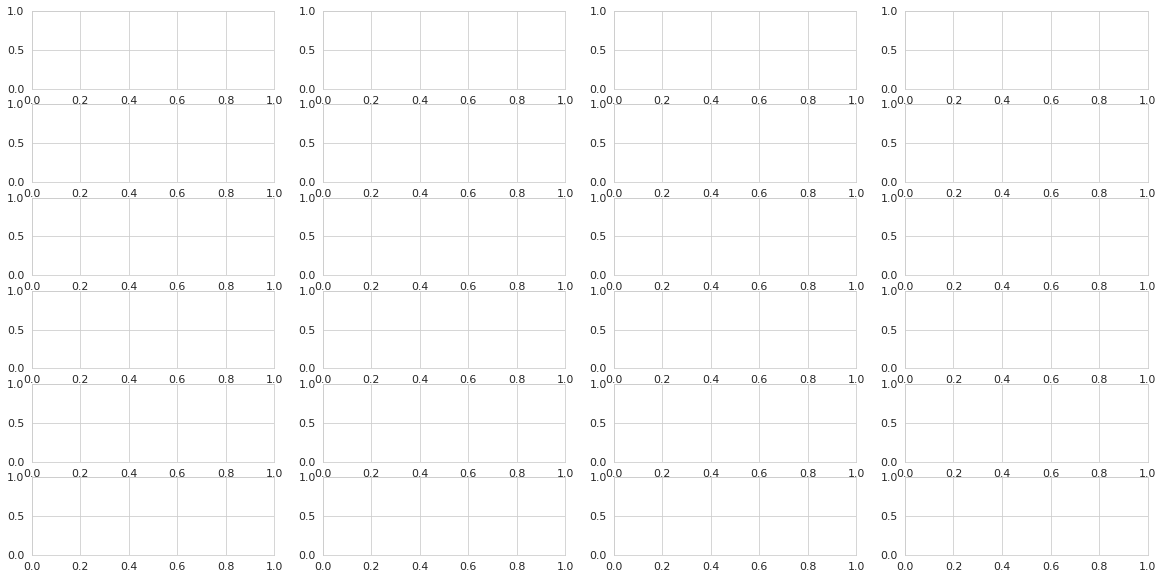

In [14]:
fig = plt.figure(figsize=(20,10))
plt.rc('font', size=11)

masks = [['2 contrast VQA round 1',
          ((df['eval_pool'] == '2 contrast') &
           (df['eval_dataset'] == 'VQA') &
           (df['round'] == 1))],
         ['2 contrast VQA',
          ((df['eval_pool'] == '2 contrast') &
           (df['eval_dataset'] == 'VQA') &
           (df['final_round'] == True))],
         ['2 random VQA',
          ((df['eval_pool'] == '2 random') &
           (df['eval_dataset'] == 'VQA') &
           (df['final_round'] == True))],
         ['9 random VQA',
          ((df['eval_pool'] == '9 random') &
           (df['eval_dataset'] == 'VQA') &
           (df['final_round'] == True))],
         ['9 random AWA',
          ((df['eval_pool'] == '9 random') &
           (df['eval_dataset'] == 'AWA') &
           (df['final_round'] == True))],
         ['9 random CUB',
          ((df['eval_pool'] == '9 random') &
           (df['eval_dataset'] == 'CUB') &
           (df['final_round'] == True))],
        ]

axes = np.array([[None, None, None, None] for _ in masks])

H = len(masks)
for i, _ in enumerate(masks):
    kwargs = {}
    if i > 0: kwargs['sharex'] = axes[0, 0]
    axes[i, 0] = fig.add_subplot(H, 4, 1 + i * 4, **kwargs)
    if i > 0: kwargs['sharex'] = axes[0, 1]
    axes[i, 1] = fig.add_subplot(H, 4, 2 + i * 4, **kwargs)
    if i > 0: kwargs['sharex'] = axes[0, 2]
    axes[i, 2] = fig.add_subplot(H, 4, 3 + i * 4, **kwargs)
    if i > 0: kwargs['sharex'] = axes[0, 3]
    axes[i, 3] = fig.add_subplot(H, 4, 4 + i * 4, **kwargs)

# model masks
mask1 = ((df['stage'] == 'pre') &
         (df['short_key'] == 'Stage 1'))
mask2 = ((df['final_pool'] == df['eval_pool']) &
         (df['short_key'] == 'Non-Var Cont Fine Decoder')) # 'Non-Var Cont Stage 2.B (Skip 2.A)'
mask3 = ((df['final_pool'] == df['eval_pool']) &
         (df['short_key'] == 'DWD (Ours)'))
mask4 = ((df['final_pool'] == df['eval_pool']) &
         (df['short_key'] == 'Fine Decoder'))
model_mask = mask1 | mask2 | mask3 #| mask4

for i, mask in enumerate(masks):
    mask_name, mask = mask
    _df = df[model_mask & mask]
    
    print(mask_name)
    show_latex(_df, 'short_key', ['roundAcc', 'ques_pplx', 'max_rel_prob', 'dngrams_avg'], show_df=False)
    continue

    ax = axes[i, 0]
    sns.barplot(data=_df, x='roundAcc', y='short_key', orient='h', ax=ax)
    ax.set_ylabel(mask_name)
    if i == H - 1:
        ax.set_xlabel('Final round accuracy')
    else:
        ax.set_xlabel('')
        #ax.set_xticklabels([])
    if i == 0:
        ax.set_title(f'Task Performance')

    ax = axes[i, 1]
    sns.barplot(data=_df, x='ques_pplx', y='short_key', orient='h', ax=ax)
    if i == 0:
        ax.set_title(f'Question Perplexity')
    if i == H - 1:
        ax.set_xlabel('Perplexity of generated questions relative to a VQA language model')
    else:
        ax.set_xlabel('')
        #ax.set_xticklabels([])
    ax.get_yaxis().set_visible(False)

    ax = axes[i, 2]
    sns.barplot(data=_df, x='max_rel_prob', y='short_key', orient='h', ax=ax)
    if i == 0:
        ax.set_title(f'Question Relevance')
    if i == H - 1:
        ax.set_xlabel('Relevance of most relevant image')
    else:
        ax.set_xlabel('')
        #ax.set_xticklabels([])
    ax.get_yaxis().set_visible(False)

    ax = axes[i, 3]
    sns.barplot(data=_df, x='dngrams_avg', y='short_key', orient='h', ax=ax)
    if i == 0:
        ax.set_title(f'Diversity')
    if i == H - 1:
        ax.set_xlabel('Diverse ngram percent averaged over n=1,2,3,4')
    else:
        ax.set_xlabel('')
        #ax.set_xticklabels([])
    ax.get_yaxis().set_visible(False)


#plt.tight_layout()

#plt.savefig(f'data/figures/generalization_summary.png')

# Per-Round Accuracy

<Figure size 3600x2400 with 0 Axes>

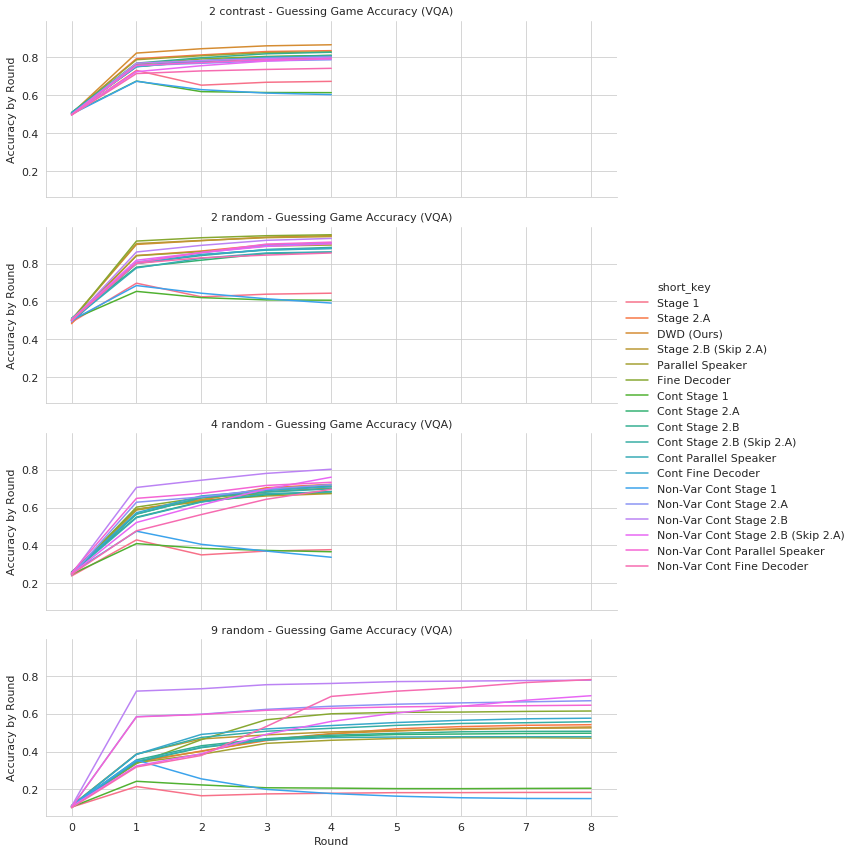

<Figure size 432x288 with 0 Axes>

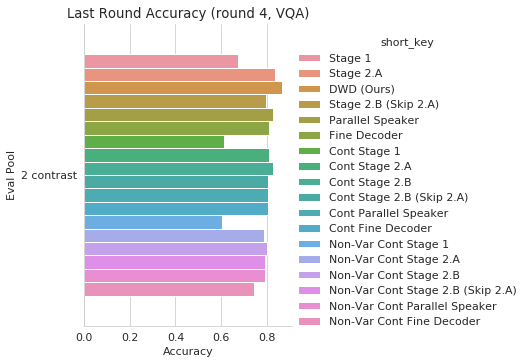

<Figure size 432x288 with 0 Axes>

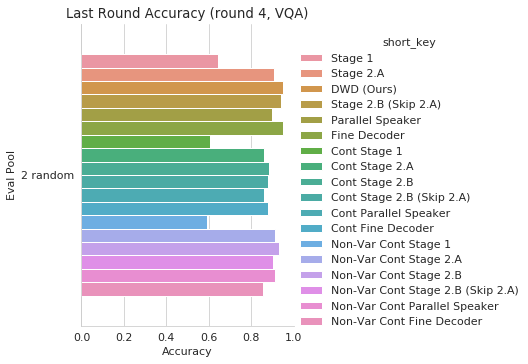

<Figure size 432x288 with 0 Axes>

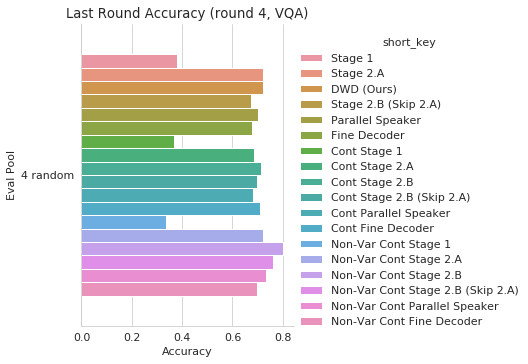

<Figure size 432x288 with 0 Axes>

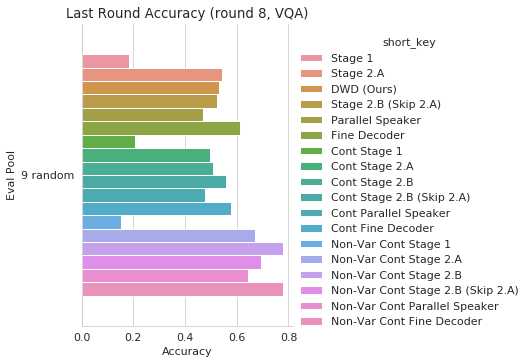

<Figure size 432x288 with 0 Axes>

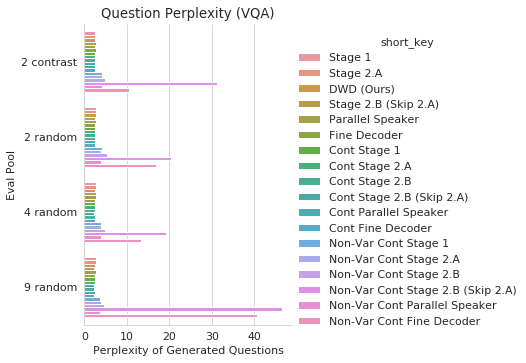

<Figure size 432x288 with 0 Axes>

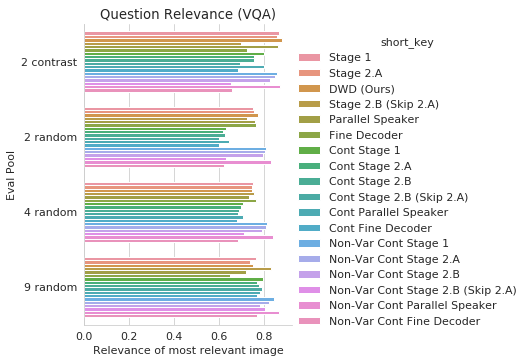

<Figure size 432x288 with 0 Axes>

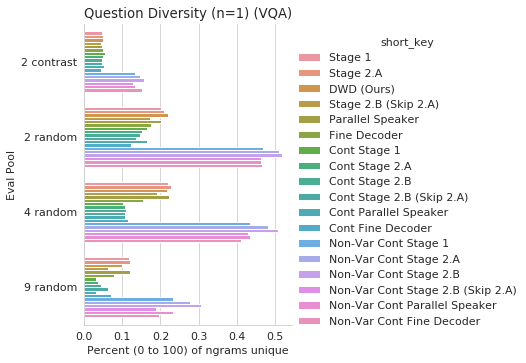

<Figure size 432x288 with 0 Axes>

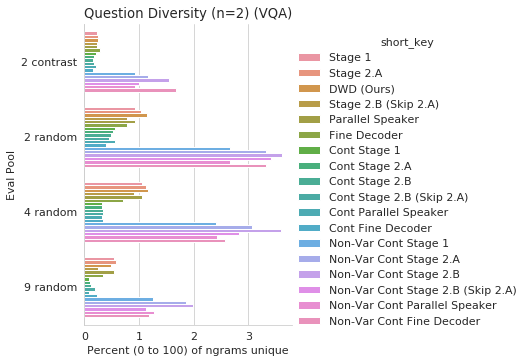

<Figure size 432x288 with 0 Axes>

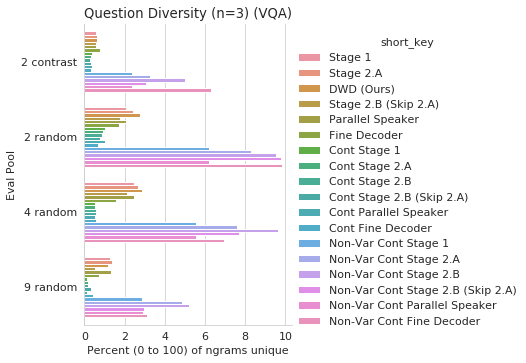

<Figure size 432x288 with 0 Axes>

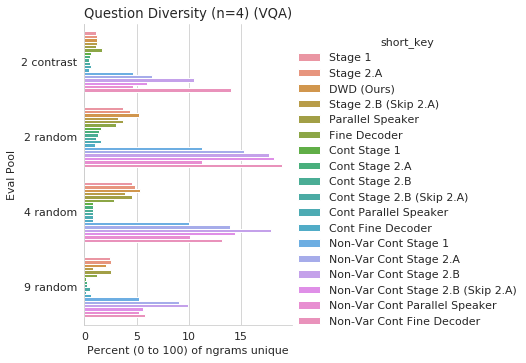

<Figure size 3600x2400 with 0 Axes>

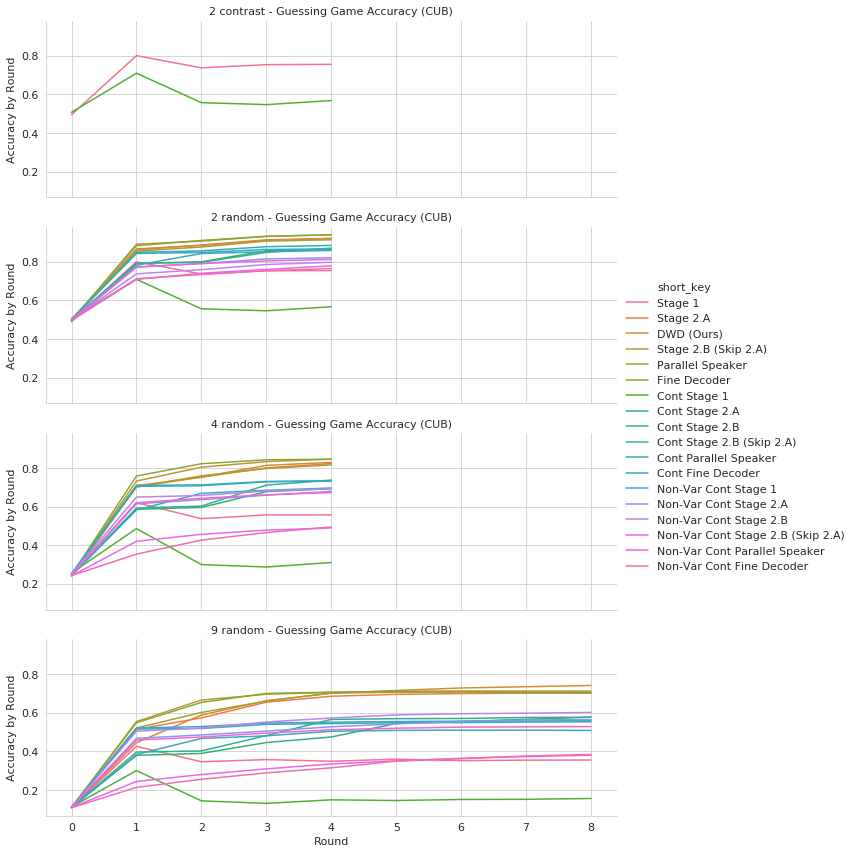

<Figure size 432x288 with 0 Axes>

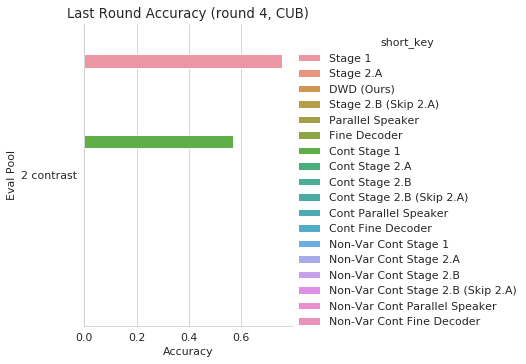

<Figure size 432x288 with 0 Axes>

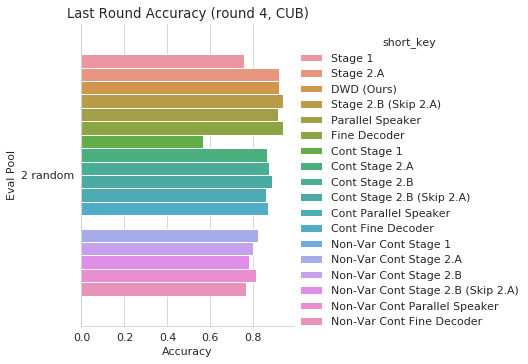

<Figure size 432x288 with 0 Axes>

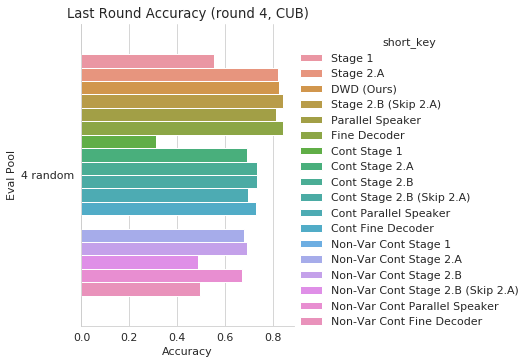

<Figure size 432x288 with 0 Axes>

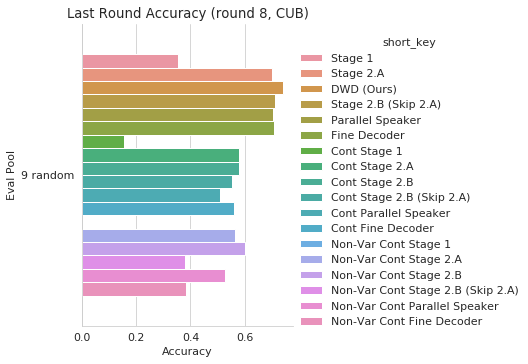

<Figure size 432x288 with 0 Axes>

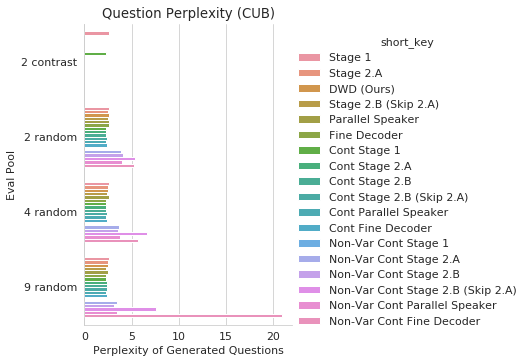

<Figure size 432x288 with 0 Axes>

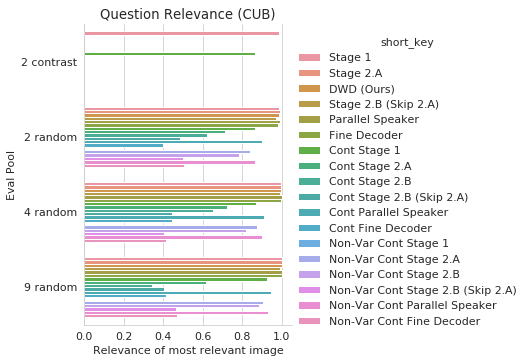

<Figure size 432x288 with 0 Axes>

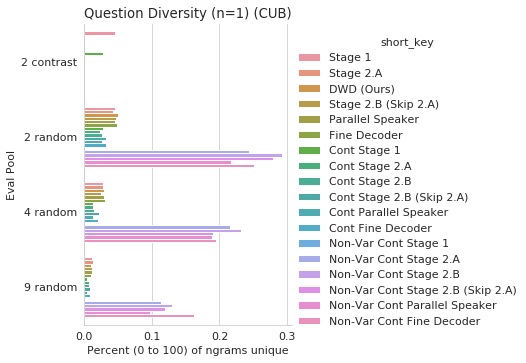

<Figure size 432x288 with 0 Axes>

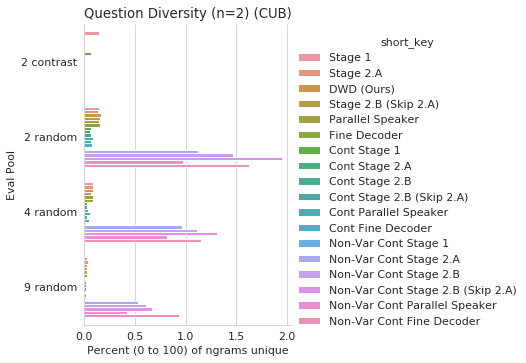

<Figure size 432x288 with 0 Axes>

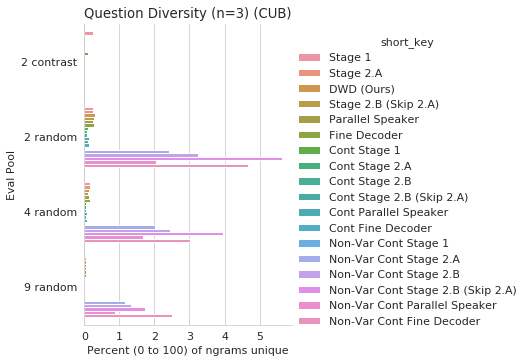

<Figure size 432x288 with 0 Axes>

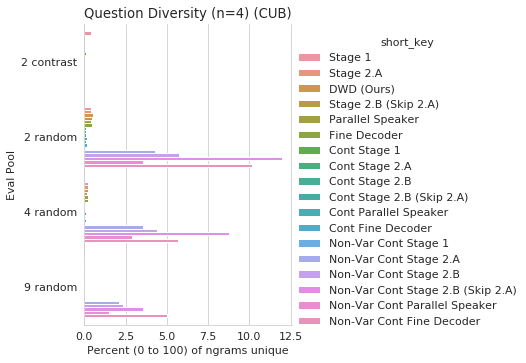

<Figure size 3600x2400 with 0 Axes>

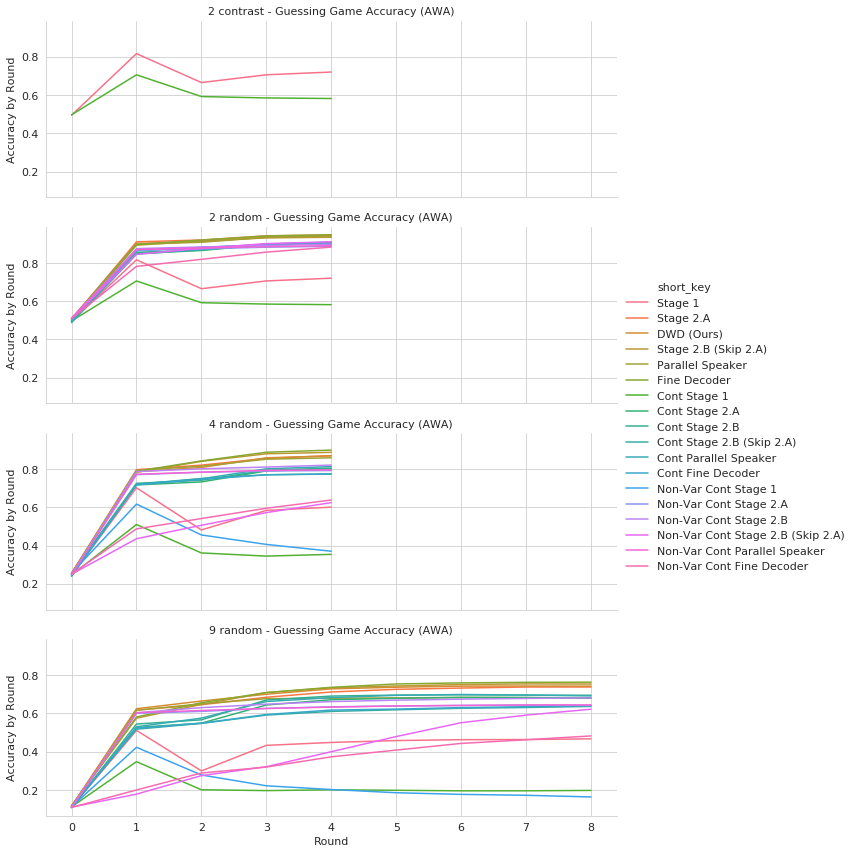

<Figure size 432x288 with 0 Axes>

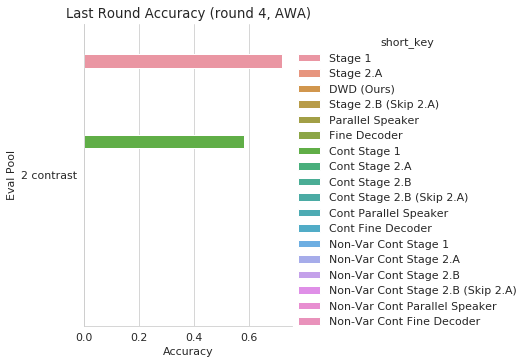

<Figure size 432x288 with 0 Axes>

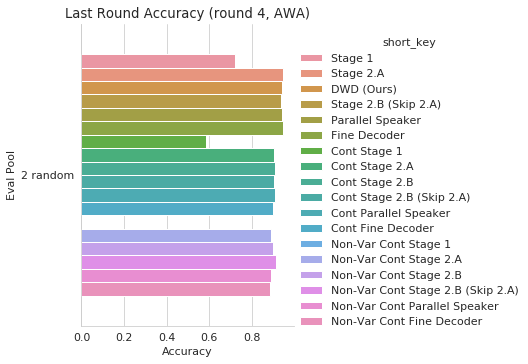

<Figure size 432x288 with 0 Axes>

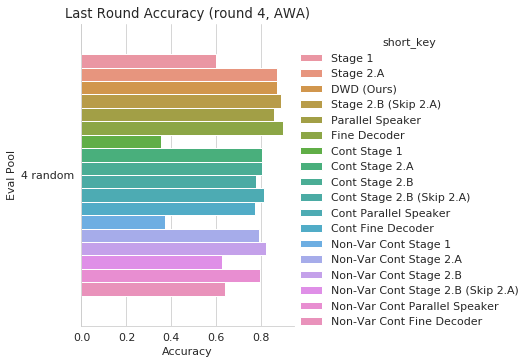

<Figure size 432x288 with 0 Axes>

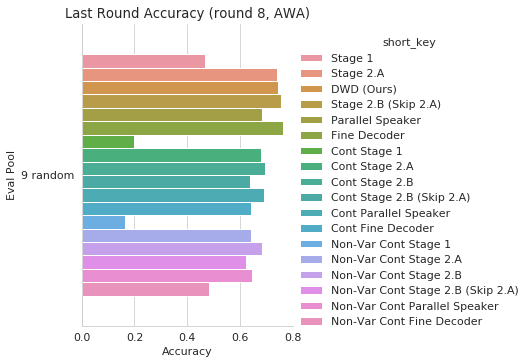

<Figure size 432x288 with 0 Axes>

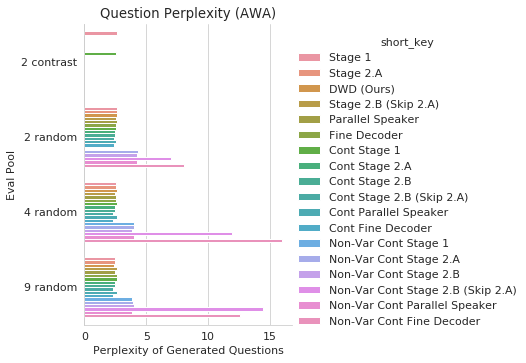

<Figure size 432x288 with 0 Axes>

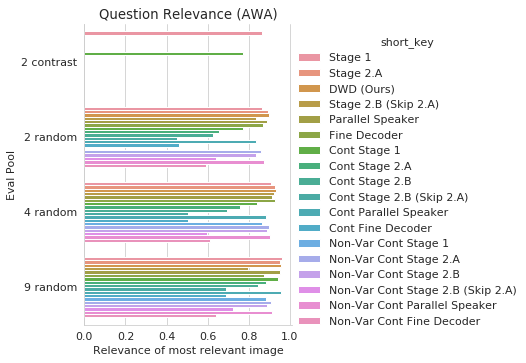

<Figure size 432x288 with 0 Axes>

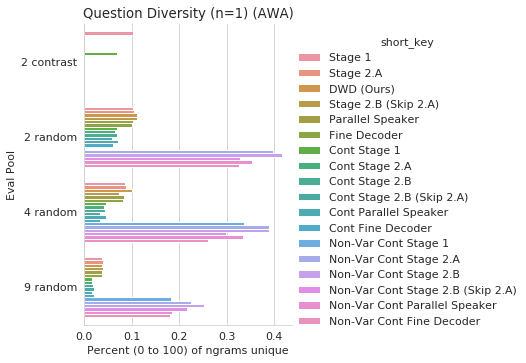

<Figure size 432x288 with 0 Axes>

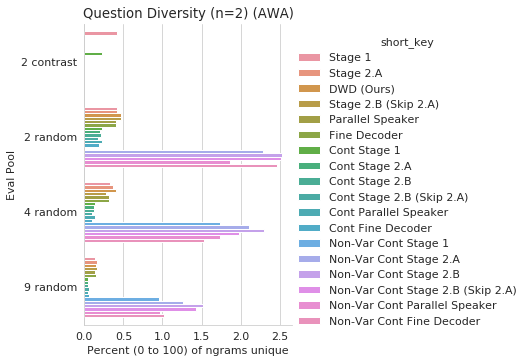

<Figure size 432x288 with 0 Axes>

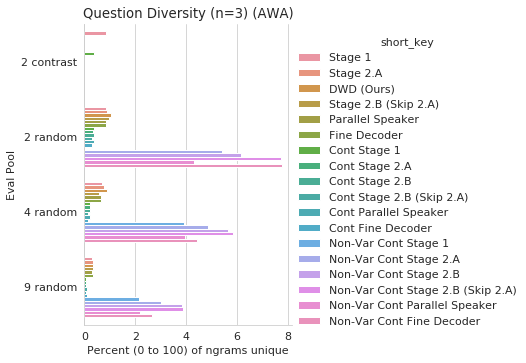

<Figure size 432x288 with 0 Axes>

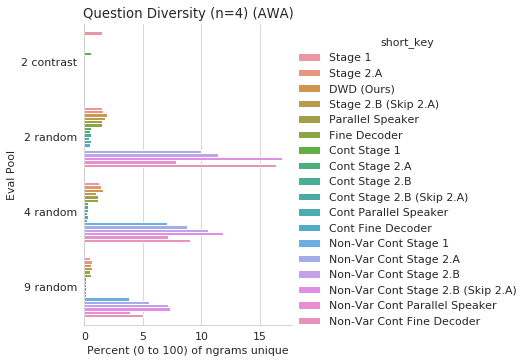

In [15]:
for dataset in ['VQA', 'CUB', 'AWA']:

    #_df = df
    #_df = df[df['final_pool'] == df['eval_pool']]
    _df = df[((df['final_pool'] == df['eval_pool']) | (df['stage'] == 'pre')) &
             (df['eval_dataset'] == dataset)]
    #_df = df[(df['final_pool'] == df['eval_pool']) | (df['final_pool'] == '4 random') | (df['key'] == '2 contrast - 2 contrast - 2 contrast')]
    #_df = df[(((df['final_pool'] == df['eval_pool']) | (df['final_pool'] == '2 contrast') | (df['final_pool_size'] == df['eval_pool_size'])) &
    #          ((df['stage2_freeze'] != 'none'))) | 
    #         ((df['final_pool'] == df['eval_pool']) & (df['stage2_freeze'] == 'none'))]
    #_df = df[(df['final_pool'] == '4 random') | (df['final_pool'] == '9 random')]

    plt.figure(dpi=600)
    fg = sns.FacetGrid(_df, row='eval_pool', aspect=3)
    fg.map(sns.lineplot, 'round', 'roundAcc', 'short_key', hue_order=hue_order)
    fg.set_xlabels('Round')
    fg.set_ylabels('Accuracy by Round')
    fg.add_legend()
    #for ax in fg.axes.ravel():
    #    #ax.set_ylim(0, 1)
    #    ax.legend()
    fg.set_titles('{row_name} - ' + f'Guessing Game Accuracy ({dataset})')
    plt.savefig(f'data/figures/task_{dataset}.png')

    for i, eval_pool in enumerate(sorted(_df.eval_pool.unique())):
        plt.figure()
        final_round = {
            '2 contrast': 4,
            '2 random': 4,
            '4 random': 4,
            '9 random': 8,
        }[eval_pool]
        __df = _df[(_df['round'] == final_round) & (_df['eval_pool'] == eval_pool)]
        sns.catplot(data=__df, x='roundAcc', hue='short_key', y='eval_pool', hue_order=hue_order, kind='bar', orient='h')
        plt.xlabel('Accuracy')
        plt.ylabel('Eval Pool')
        plt.title(f'Last Round Accuracy (round {final_round}, {dataset})')
        plt.savefig(f'data/figures/last_acc_{dataset}.png')

    plt.figure()
    sns.catplot(data=_df, x='ques_pplx', hue='short_key', y='eval_pool', hue_order=hue_order, kind='bar', orient='h')
    plt.xlabel('Perplexity of Generated Questions')
    plt.ylabel('Eval Pool')
    plt.title(f'Question Perplexity ({dataset})')
    plt.savefig(f'data/figures/fluency_{dataset}.png')

    plt.figure()
    sns.catplot(data=_df, x='max_rel_prob', hue='short_key', y='eval_pool', hue_order=hue_order, kind='bar', orient='h')
    plt.xlabel('Relevance of most relevant image')
    plt.ylabel('Eval Pool')
    plt.title(f'Question Relevance ({dataset})')
    plt.savefig(f'data/figures/relevance_{dataset}.png')

    for n in [1, 2, 3, 4]:
        plt.figure()
        sns.catplot(data=_df, x=f'dngrams_{n}', hue='short_key', y='eval_pool', hue_order=hue_order, kind='bar', orient='h')
        plt.xlabel('Percent (0 to 100) of ngrams unique')
        plt.ylabel('Eval Pool')
        plt.title(f'Question Diversity (n={n}) ({dataset})')
        plt.xlim
        plt.savefig(f'data/figures/diversity_{n}_{dataset}.png')